In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [30]:
###Set constants and parameters

##input params
H = 0.42 #no units,ratio #Hematocrit assumed to be constant
M = 20e-9 #mol_ O2/(mL/s) #Taken from table 2 from Wiley Payne paper
cHb = 0.2 #mL_O2/m #Taken from table 2 from Wiley Payne paper
paO2_bar_t = 15 #mmHG #Taken from table 2 from Wiley Payne paper

##SI them
M = M*10e3
cHb = cHb*10e-3
paO2_bar_t = paO2_bar_t*133.322

###Set up input data

##reset df
df = None

##Input data
#all data taken from Payne article
df = pd.DataFrame({'Name': ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'C', 'V6', 'V5', 'V4', 'V3', 'V2', 'V1'], 
                   'Number': [1, 2, 4, 8, 16, 32, 64, 32, 16, 8, 4, 2, 1],
                   'Diameter(µm)': [23.97, 19.17, 15.28, 12.08, 9.46, 7.32, 8, 11.51, 14.53, 17.79, 21.45, 25.70, 30.77],
                   'Length(µm)': [1267.6, 930.3, 543.6, 302.3, 161.2, 154.7, 243.9, 473.9, 272.3, 426.6, 632.5, 844.2, 936.3],
                   'Viscocity(mPAs)': [1.59, 1.50, 1.42, 1.34, 1.28, 1.23, 1.24, 1.33, 1.40, 1.48, 1.55, 1.62, 1.7],
                   'Pressure Drop(mmHg)': [6.93, 5.87, 4.02, 2.70, 1.82, 2.35, 2.62, 1.27, 0.61, 0.89, 1.31, 1.78, 2.01],
                   'Saturation': [0.94, 0.93, 0.92, 0.89, 0.84, 0.765, 0.665, 0.61, 0.5975, 0.5875, 0.5825, 0.5775, 0.5725]
                  })

##change units
df['Diameter(µm)'] = df['Diameter(µm)']*1e-6
df['Length(µm)'] = df['Length(µm)']*1e-6
df['Viscocity(mPAs)'] = df['Viscocity(mPAs)']*1e-3
df['Pressure Drop(mmHg)'] = df['Pressure Drop(mmHg)']*133.322
##rename the titles for the units
df = df.rename(columns={'Diameter(µm)':'Diameter(m)', 'Length(µm)':'Length(m)', 'Viscocity(mPAs)':'Viscocity(PAs)', 'Pressure Drop(mmHg)':'Pressure Drop(Pa)'})

###Calculate Flows

##Calculate resitances of each single vessel for each type
df['Resistance for U'] = 32 * df['Viscocity(PAs)'] * df['Length(m)'].div(df['Diameter(m)']**2)
df['Resistance for Q'] = 128 * df['Viscocity(PAs)'] * df['Length(m)'].div(math.pi*(df['Diameter(m)']**4))

##Alter resistances for C
#These are aross each pressure drop (explains the doubled resistance for the capillaries as in paralell so have half the flow each (flow is shared))
df.loc[df.index[df['Name'] == 'C'][0],'Resistance for U'] = df.loc[df.index[df['Name'] == 'C'][0],'Resistance for U']*2
df.loc[df.index[df['Name'] == 'C'][0],'Resistance for Q'] = df.loc[df.index[df['Name'] == 'C'][0],'Resistance for Q']*2

##Calculate flow in a single vessel
df['U in single(m/s)'] = df['Pressure Drop(Pa)'].div(df['Resistance for U'])
df['Q in single(m^3/s)'] = df['Pressure Drop(Pa)'].div(df['Resistance for Q'])

########temp calculate the saturations - CANT GET TO WORK
#df['Vt'] = np.zeros(13)
#S_temp = pd.DataFrame({'Saturation': np.zeros(13)})
#S_temp['Saturation'][0] = 0.94
#df = pd.concat([df,S_temp], axis=1)

#df.loc[0,'Vt'] = df.loc[0,'Q in single(m^3/s)']*cHb*H*df.loc[0,'Saturation']/M
#for i in range(12):
    #df.loc[i+1,'Saturation'] = df.loc[i,'Saturation'] - ( 2*M*df.loc[i+1,'Vt'] ) / ( cHb*H*( df.loc[i,'Q in single(m^3/s)'] + df.loc[i+1,'Q in single(m^3/s)'] ) )
    #df.loc[i+1,'Saturation'] = ( M*df.loc[i+1,'Vt'] ) / ( cHb*H*( df.loc[i,'Q in single(m^3/s)'] + df.loc[i+1,'Q in single(m^3/s)'] ) )
    #df.loc[i+1,'Vt'] = df.loc[i+1,'Q in single(m^3/s)']*cHb*H*df.loc[i+1,'Saturation']/M
    
###Next stage

##Calculate Vt
#Check what Vt is calculated in units and add to name 
df['Vt'] = df['Q in single(m^3/s)']*cHb*H*df['Saturation']/M
#This will remain fixed.


##S and partial O2 relationship given by servinghaus 1979
def check_imag_roots_real(all_roots):
    counter = 0
    sols = 0
    for i in range(len(all_roots)):
        if all_roots[i].imag <= 1e-13 and all_roots[i].imag >= -1e-13:
            sols = all_roots[i].real
            counter += 1
    if counter != 1:
        print('Something seems wrong with the partial presure to Saturation cubic solver as not one solution is returned.')
    return sols
 
for i in range(len(df['Saturation'])):
    root_temp = None
    sols = 0
    root_temp = np.roots([1,0,150,23400*df.loc[i,'Saturation']/(df.loc[i,'Saturation']-1)]) #gives mmHg , *133.322
    sols = check_imag_roots_real(root_temp) 
    #sols = sols*133.322 ###Remove this step if want in mmHg
    df.loc[i,'partial pressure blood(pa)'] = sols
#Checked partial pressure against typical values online and it seems bang on.

###Now calculate the partial pressure of O2 in tissue
#Will take my vessel average partial pressure to be the 0.5(pin + pout)
#need h
#all units were in mm so i played around with this equation from the paper
df['X-Area wall(m^2)'] = 10e-6 * np.pi * ( 0.16*(df['Diameter(m)']*10e3)**2 + 1.4*(df['Diameter(m)']*10e3) + 14 )
df['wall thickness(mm)'] = ( -(df['Diameter(m)']*10e3) + np.sqrt((df['Diameter(m)']*10e3)**2 + (4*(df['X-Area wall(m^2)']*10e6)/np.pi)) ) / 2

Text(0.5, 1.0, 'partial pressure blood(pa)')

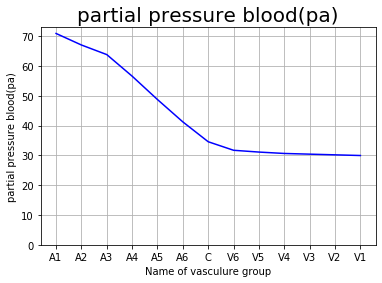

In [31]:
fig,ax = plt.subplots()
plt.plot(df['Name'],df['partial pressure blood(pa)'], color='b')
plt.grid(which='both')
plt.ylabel('partial pressure blood(pa)')
plt.xlabel('Name of vasculure group')
ax.set_ylim(bottom=0)
plt.title('partial pressure blood(pa)', fontsize=20)

In [28]:
###Find Total PRessure Drop
df.sum(axis=0)

Name                          A1A2A3A4A5A6CV6V5V4V3V2V1
Number                                              190
Diameter(m)                                  0.00021703
Length(m)                                     0.0071894
Viscocity(PAs)                                  0.01868
Pressure Drop(Pa)                               4556.95
Saturation                                       9.4775
Resistance for U                            1.38035e+06
Resistance for Q                            1.42458e+16
U in single(m/s)                               0.046493
Q in single(m^3/s)                          1.46705e-11
Vt                                          4.63002e-11
partial pressure blood(pa)                        75543
X-Area wall(m^2)                             0.00581529
wall thickness(mm)                              489.462
dtype: object

In [29]:
df

,Name,Number,Diameter(m),Length(m),Viscocity(PAs),Pressure Drop(Pa),Saturation,Resistance for U,Resistance for Q,U in single(m/s),Q in single(m^3/s),Vt,partial pressure blood(pa),X-Area wall(m^2),wall thickness(mm)
0,A1,1,0.000024,0.001268,0.00159,923.92146,0.9400,112251.787408,2.487524e+14,0.008231,3.714221e-12,1.466374e-11,9448.713176,0.000451,37.754834
1,A2,2,0.000019,0.000930,0.00150,782.60014,0.9300,121512.241594,4.210037e+14,0.006441,1.858891e-12,7.260829e-12,8933.285879,0.000448,37.685563
2,A3,4,0.000015,0.000544,0.00142,535.95444,0.9200,105796.441983,5.769451e+14,0.005066,9.289523e-13,3.589472e-12,8504.173651,0.000447,37.629984
3,A4,8,0.000012,0.000302,0.00134,359.96940,0.8900,88829.875883,7.750600e+14,0.004052,4.644407e-13,1.736079e-12,7539.405435,0.000445,37.584641
4,A5,16,0.000009,0.000161,0.00128,242.64604,0.8400,73780.690031,1.049713e+15,0.003289,2.311547e-13,8.155136e-13,6493.583191,0.000444,37.547772
5,A6,32,0.000007,0.000155,0.00123,313.30670,0.7650,113637.910956,2.700295e+15,0.002757,1.160268e-13,3.727943e-13,5494.390378,0.000443,37.517828
6,C,64,0.000008,0.000244,0.00124,349.30364,0.6650,302436.000000,6.016773e+15,0.001155,5.805498e-14,1.621476e-13,4607.197712,0.000443,37.527326
7,V6,32,0.000012,0.000474,0.00133,169.31894,0.6100,152243.121797,1.463178e+15,0.001112,1.157200e-13,2.964746e-13,4225.885530,0.000445,37.576600
8,V5,16,0.000015,0.000272,0.00140,81.32642,0.5975,57782.247044,3.484764e+14,0.001407,2.333772e-13,5.856600e-13,4145.939098,0.000446,37.619326
9,V4,8,0.000018,0.000427,0.00148,118.65658,0.5875,63838.202298,2.568259e+14,0.001859,4.620117e-13,1.140014e-12,4083.464047,0.000448,37.665789
